In [105]:
from pydantic import BaseModel,Field
from typing import Literal,TypedDict
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,START,END

In [106]:
load_dotenv()

True

In [107]:
model=ChatGroq(model="llama-3.1-8b-instant")

In [108]:
class Sentiment(BaseModel):
    sentiment_type:Literal["positive","negative"]

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [109]:
structured_output1=model.with_structured_output(Sentiment)
structured_output2=model.with_structured_output(DiagnosisSchema)

In [110]:
test_prompt1=f"Find the sentiment of this prompt: I am feeling very happy"
structured_output1.invoke(test_prompt1).sentiment_type

'positive'

In [111]:
class StateSchema(TypedDict):

    review:str
    sentiment:Literal["positive","negative"]
    diagnosis:dict
    response:str




In [112]:
def find_sentiment(state:StateSchema):
    prompt=f"Find the sentiment of the following review: {state['review']}"
    result=structured_output1.invoke(prompt).sentiment_type

    return {'sentiment':result}

def check_sentiment(state:StateSchema)->Literal["positive_response","run_diagnostic"]:
    if state["sentiment"]=="positive":
        return "positive_response"
    else:
        return "run_diagnostic"


In [113]:
def positive_response(state:StateSchema):
    prompt=f"We received a postive response that is {state['review']}. Can you please provide a warm thank you message along with telling the user to provide a feedback in our website"
    result=model.invoke(prompt)

    return {'response':result.content}

def run_diagnostic(state:StateSchema):
    prompt=f"Can you evaluate the review :{state['review']} on three key metrics:issue_type,tone and urgency"
    result=structured_output2.invoke(prompt)

    return{
        'diagnosis':result.model_dump()
    }

def negative_response(state:StateSchema):
    diagnosis=state["diagnosis"]
    prompt = f"""You are a support assistant.
                The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
                Write an empathetic, helpful resolution message."""
    result=model.invoke(prompt).content

    return {
        'response':result
    }

In [114]:
graph=StateGraph(StateSchema)

In [115]:
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnostic',run_diagnostic)
graph.add_node('negative_response',negative_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnostic','negative_response')
graph.add_edge('negative_response',END)

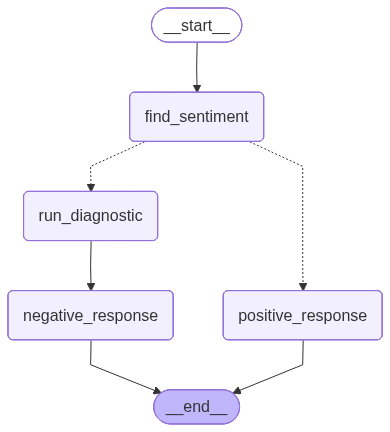

In [116]:
workflow=graph.compile()
workflow

In [117]:
intial_state={
    'review':test_prompt1
}
workflow.invoke(intial_state)

{'review': 'Find the sentiment of this prompt: I am feeling very happy',
 'sentiment': 'positive',
 'response': 'Here\'s a possible response:\n\n"Wow, that\'s amazing to hear that you\'re feeling very happy! We\'re thrilled to know that our effort has brought a smile to your face. Thank you so much for your kind words! We\'re always here to help and support you. To help us improve, would you mind taking a minute to provide some feedback on our website? Your input will be invaluable in shaping our services to better meet your needs. Please visit our website and let us know how we\'re doing. Thank you again for your wonderful feedback!"'}

In [ ]:
test_prompt2=f"Not happy with your customer service. Will never visit again"

intial_state={
    'review':test_prompt2
}
workflow.invoke(intial_state)

{'review': 'Not happy with your haircut service. Will never visit again',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "Subject: Urgent: Resolution to Bug Issue\n\nDear [User's Name],\n\nI apologize for the frustration and inconvenience caused by the bug issue you're experiencing. I can sense your urgency and appreciate you bringing this to our attention. I'm here to help you resolve the issue as quickly as possible.\n\nTo better assist you, could you please provide more details about the bug, such as:\n\n1. What exactly is happening (e.g., error messages, unexpected behavior)?\n2. When did the issue start occurring?\n3. Have you tried any troubleshooting steps already?\n\nIn the meantime, I want to assure you that I'm escalating this issue to our development team to ensure we address it promptly. We'll work closely to find a solution and prevent similar issues in the future.\n\nPlease feel free to respond to this email